In [ ]:
# Be sure you're using the stable versions of both `tensorflow` and
# `tensorflow-text`, for binary compatibility.
! pip uninstall -y tf-nightly keras-nightly
! pip install tensorflow
! pip install tensorflow-text
! pip install pymorphy2
from IPython.display import clear_output
clear_output()

In [ ]:
import collections
import pathlib
import re

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization

import tensorflow_text as tf_text
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
import nltk
from pymorphy2 import MorphAnalyzer

nltk.download('stopwords')
stopwords = stopwords.words('russian')
morph = MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def get_real_label(sigmoid_out):
  if sigmoid_out >= 0.5:
    return 1
  else:
    return 0


def get_real_preds(predictions):
  return np.array(list(map(get_real_label, predictions)))

In [ ]:
def lemmatize(sentence):
    tokens = []
    for token in sentence.split():
        if token and token not in stopwords:
            token = token.strip()
            token = morph.normal_forms(token)[0]

            tokens.append(token)
    if len(tokens) > 0:
        return ' '.join(tokens)
    return ''


good_pattern = re.compile('[^а-яА-Я ]')
space_pattern = re.compile(' +')


def clean_text(text):
    new_text = good_pattern.sub(' ', text).strip()
    new_text = re.sub(space_pattern, ' ', new_text)
    return new_text


def normalize(text):
  return lemmatize(clean_text(text.lower()))

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
#Change the current working directory to the path of Google Cloud Drive
path="/content/drive/MyDrive/ML"
os.chdir(path)
print(os.listdir(path))
os.chdir('/content')

['backbone_labeled.json', 'backbone_labeled1.json', 'qa_labeled1.json', 'backbone_labeled2.json', 'qa_labeled.json', 'ee66fe54-da44-411e-a67e-19bacd205646.json']


In [ ]:
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk


nltk.download('stopwords')
stopwords = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import json
with open("/content/drive/MyDrive/ML/qa_labeled.json", 'r', encoding='utf-8') as fdata:
  data_js = json.load(fdata)

In [ ]:
import pandas as pd

labeled_pairs = []

for row in data_js:
  pairs = row['pairs']
  for pair in pairs:
    pair['question'] = pair['question'].lower()
    pair['answer'] = pair['answer'].lower()
  labeled_pairs.extend(pairs)

js_df = pd.read_json(json.dumps(labeled_pairs))
js_df.to_csv('file.csv')

In [ ]:
data = pd.read_csv("file.csv")
print(data.head())
print(len(data))

   Unnamed: 0                                           question  \
0           0  подскажите, пожалуйста, как перевести регионал...   
1           1  подскажите, пожалуйста, как перевести регионал...   
2           2  как женщине которая старше ... как женщине кот...   
3           3  как женщине которая старше ... как женщине кот...   
4           4  что делать если вы пригласили девушку в рестор...   

                                              answer  label  
0  к сожалению, всей процедуры рассказать не могу...      1  
1                         скрыть ошибку косметолога.      0  
2  ну если поймет, то к дружбе прибавится и любов...      1  
3  проверить антивирусом, не поможет форматирование.      0  
4  оставить девушку в ресторане, а самому быстро ...      1  
305714


In [ ]:
row = data.iloc[124]
row_text = []
row_text.append(row['question'])
row_text.append(row['answer'])

In [ ]:
def clean_string(text):
  text = ''.join([word for word in text if word not in string.punctuation])
  text = text.lower()
  text = ' '.join([word for word in text.split() if word not in stopwords])
  return text

In [ ]:
cleaned = list(map(clean_string, row_text))
cleaned

['почему почему разделе философия стало скучнопочему ответы душипочему вопросы сердца это философияили просто убиваем время ждем просветленияэх',
 'родари']

In [ ]:
vectorizer = CountVectorizer().fit_transform(cleaned)
vectors = vectorizer.toarray()
vectors

array([[1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
csim = cosine_similarity(vectors)
csim

array([[1., 0.],
       [0., 1.]])

In [ ]:
def cosine_sim_vectors(vec1, vec2):
  vec1 = vec1.reshape(1, -1)
  vec2 = vec2.reshape(1, -1)
  return cosine_similarity(vec1, vec2)[0][0]

In [ ]:
cosine_sim_vectors(vectors[0], vectors[1])

0.0

In [ ]:
def check_pair_is_good(question, answer, min_similarity=0):
  row_text = []
  row_text.append(question)
  row_text.append(answer)
  cleaned = list(map(clean_string, row_text))
  vectorizer = CountVectorizer().fit_transform(cleaned)
  vectors = vectorizer.toarray()
  return cosine_sim_vectors(vectors[0], vectors[1]) > min_similarity

In [ ]:
labeled_pairs = []

counter = 0
total = len(data_js)

for row in data_js:
  counter += 1
  if counter % 10000 == 0:
    print(f"Processed {counter}/{total}")
  pairs = row['pairs']
  skip = False
  for pair in pairs:
    pair['question'] = pair['question'].lower()
    pair['answer'] = pair['answer'].lower()
    if not check_pair_is_good(pair['question'], pair['answer']):
      skip = True
      break
  if skip:
    continue
  labeled_pairs.extend(pairs)

js_df = pd.read_json(json.dumps(labeled_pairs))
js_df.to_csv('file.csv')

Processed 10000/152857
Processed 20000/152857
Processed 30000/152857
Processed 40000/152857
Processed 50000/152857
Processed 60000/152857
Processed 70000/152857
Processed 80000/152857
Processed 90000/152857
Processed 100000/152857
Processed 110000/152857
Processed 120000/152857
Processed 130000/152857
Processed 140000/152857
Processed 150000/152857


In [ ]:
data = pd.read_csv("file.csv")
print(data.head())
print(len(data))

   Unnamed: 0                                           question  \
0           0  почему еще сегодня так многие думают, что немц...   
1           1  почему еще сегодня так многие думают, что немц...   
2           2  почему я не могу смотреть людям в глаза? и на ...   
3           3  почему я не могу смотреть людям в глаза? и на ...   
4           4  почему так??? мы расстались давно, но он не ка...   

                                              answer  label  
0                      оверманс ничего не доказывал.      1  
1                       паутина.. . точно паутина!!!      0  
2  афазия, это речевые нарушения, связанные с пор...      0  
3  комплекс страх    кстати меня тоже это интерес...      1  
4  раз и навсегда это не метод! порви два и на оп...      1  
4420


In [ ]:
from sklearn.model_selection import train_test_split
data["pair"] = data[['question', 'answer']].agg(' '.join, axis=1)
data_features = data.copy()
train, test = train_test_split(data.copy(), train_size=0.7)
data_labels_train = train['label']
data_features1_train = train['question']
data_features2_train = train['answer']

data_labels_test = test['label']
data_features1_test = test['question']
data_features2_test = test['answer']

data_features1_train = data_features1_train.apply(normalize)
data_features2_train = data_features2_train.apply(normalize)

data_features1_test = data_features1_test.apply(normalize)
data_features2_test = data_features2_test.apply(normalize)

data_labels = data_features['label']
data_features = data_features['pair'].apply(normalize)

print(data_features.head())
print(data_features.iloc[0])
print(data_labels.shape)

0    почему сегодня многие думать немец точно учиты...
1    почему сегодня многие думать немец точно учиты...
2    почему мочь смотреть человек глаз человек наво...
3    почему мочь смотреть человек глаз человек наво...
4    почему расстаться давно оставить покой постоян...
Name: pair, dtype: object
почему сегодня многие думать немец точно учитывать свой потеря оверманс доказать обратный оверманс доказывать
(4420,)


In [ ]:
data_features_tensor= tf.convert_to_tensor(data_features, dtype=tf.string)
data_labels_tensor = tf.constant(data_labels)
enc_dataset = tf.data.Dataset.from_tensor_slices((data_features, data_labels))
# qa_dataset = tf.data.Dataset.from_tensor_slices(({'input_q': data_features1, 'input_a': data_features2}, data_labels))
# qa_dataset

In [ ]:
# Shuffle the dataset
# qa_dataset = qa_dataset.shuffle(buffer_size=len(data_features))
enc_dataset = enc_dataset.shuffle(buffer_size=len(data_features))

# Split the dataset into training and testing sets
train_dataset = tf.data.Dataset.from_tensor_slices(({'input_q': data_features1_train, 'input_a': data_features2_train}, data_labels_train))

# Batch the training and testing datasets
batch_size = 16
steps_per_epoch = len(train_dataset)//batch_size

enc_dataset = enc_dataset.batch(batch_size)

train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(({'input_q': data_features1_test, 'input_a': data_features2_test}, data_labels_test))

test_dataset = test_dataset.batch(batch_size)
steps_per_epoch = len(train_dataset)
print(f"steps_per_epoch: {steps_per_epoch}")
print(f"train_dataset: {len(train_dataset)}")
print(f"test_dataset: {len(test_dataset)}")

steps_per_epoch: 194
train_dataset: 194
test_dataset: 83


In [ ]:
VOCAB_SIZE = 35000
encoder1 = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder1.adapt(enc_dataset.map(lambda text, label: text))
encoder2 = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder2.adapt(enc_dataset.map(lambda text, label: text))
vocab = np.array(encoder1.get_vocabulary())

In [ ]:
vocab[200:300]

array(['поставить', 'начало', 'внимание', 'большой', 'начать', 'сидеть',
       'русский', 'пойти', 'зависеть', 'документ', 'фильм', 'решить',
       'пол', 'собака', 'просить', 'долго', 'боль', 'чувствовать',
       'полный', 'себя', 'многие', 'давно', 'возраст', 'пытаться',
       'пусть', 'ответить', 'немного', 'народ', 'красивый', 'мысль',
       'лицо', 'спать', 'появиться', 'учиться', 'проходить', 'посмотреть',
       'помощь', 'обязательно', 'волос', 'удача', 'становиться',
       'получать', 'комп', 'настоящий', 'вид', 'слышать', 'причина',
       'приходить', 'к', 'интересно', 'действительно', 'свет', 'простой',
       'называться', 'тся', 'реально', 'увидеть', 'выйти', 'вернуть',
       'быстро', 'рядом', 'попробовать', 'получаться', 'ночь', 'молодой',
       'лёгкий', 'лишь', 'тип', 'суд', 'желание', 'смерть', 'оно',
       'никак', 'мало', 'закон', 'тело', 'ставить', 'пора', 'личный',
       'здравствуйте', 'мужик', 'заранее', 'уйти', 'вещь', 'ток',
       'против', 'помога

In [ ]:
from keras.layers.serialization import lstm
input_q = tf.keras.layers.Input(shape=(1,), name='input_q', dtype=tf.string)
input_a = tf.keras.layers.Input(shape=(1,), name='input_a', dtype=tf.string)
encoder_q = encoder1(input_q)
encoder_a = encoder2(input_a)
embedding_q = tf.keras.layers.Embedding(
        input_dim=len(encoder1.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)(encoder_q)
embedding_a = tf.keras.layers.Embedding(
        input_dim=len(encoder2.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)(encoder_a)
lstm_q = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(embedding_q)
lstm_a = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(embedding_a)
lstm_out = tf.keras.layers.concatenate([lstm_q, lstm_a], axis=-1)
dropout1 = tf.keras.layers.Dropout(0.2)(lstm_out)
dense1 = tf.keras.layers.Dense(256, activation='relu')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.2)(dense1)
dense2 = tf.keras.layers.Dense(64, activation='relu')(dropout2)
dropout3 = tf.keras.layers.Dropout(0.2)(dense2)
dense3 = tf.keras.layers.Dense(32, activation='relu')(dropout3)
dropout4 = tf.keras.layers.Dropout(0.2)(dense3)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout4)

model = tf.keras.models.Model(inputs=[input_q, input_a], outputs=output)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_q (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_a (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, None)        0           ['input_q[0][0]']                
 ization)                                                                                         
                                                                                                  
 text_vectorization_1 (TextVect  (None, None)        0           ['input_a[0][0]']            

In [ ]:
checkpoint_path = 'training_1/cp.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1,
                                                 monitor='val_loss')
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [ ]:
history = model.fit(train_dataset, epochs=20,
                    validation_data=test_dataset,
                    batch_size=batch_size, callbacks=[cp_callback, es_callback])

Epoch 1/20
194/194 [==============================] - ETA: 0s - loss: 0.6931 - precision: 0.5000 - recall: 0.9516 - binary_accuracy: 0.4997
Epoch 1: val_loss improved from inf to 0.69324, saving model to training_1/cp.ckpt
194/194 [==============================] - 64s 222ms/step - loss: 0.6931 - precision: 0.5000 - recall: 0.9516 - binary_accuracy: 0.4997 - val_loss: 0.6932 - val_precision: 0.4992 - val_recall: 0.9940 - val_binary_accuracy: 0.4992
Epoch 2/20
194/194 [==============================] - ETA: 0s - loss: 0.6916 - precision: 0.5070 - recall: 0.9800 - binary_accuracy: 0.5133
Epoch 2: val_loss improved from 0.69324 to 0.69227, saving model to training_1/cp.ckpt
194/194 [==============================] - 36s 188ms/step - loss: 0.6916 - precision: 0.5070 - recall: 0.9800 - binary_accuracy: 0.5133 - val_loss: 0.6923 - val_precision: 0.5062 - val_recall: 0.9199 - val_binary_accuracy: 0.5121
Epoch 3/20
194/194 [==============================] - ETA: 0s - loss: 0.6758 - precision: 

In [ ]:
model.load_weights(checkpoint_path)

test_loss, test_pre, test_recc, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
#print(model.predict(test_dataset))

83/83 [==============================] - 3s 30ms/step - loss: 0.6856 - precision: 0.5651 - recall: 0.6692 - binary_accuracy: 0.5777
Test Loss: 0.6855506300926208
Test Accuracy: 0.5776772499084473


(0.0, 1.5374554805457592)

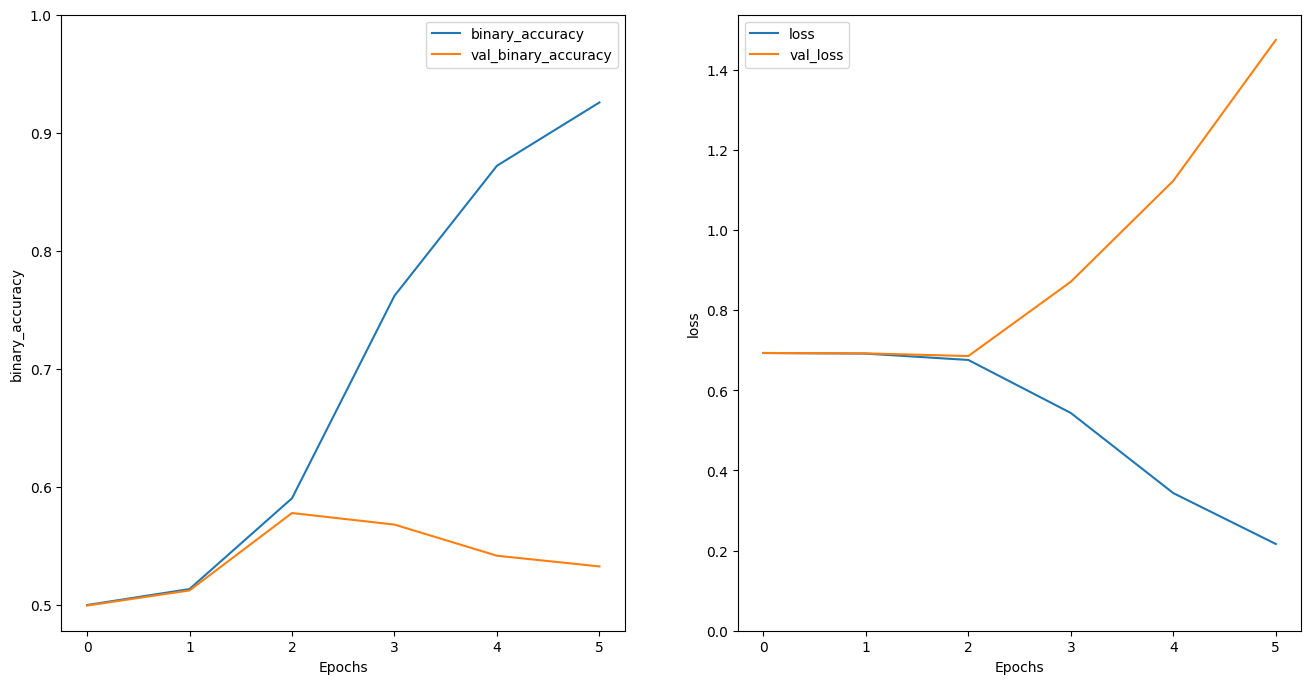

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'binary_accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
def get_real_label(sigmoid_out):
  if sigmoid_out >= 0.5:
    return 1
  else:
    return 0

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.BinaryAccuracy()])

sample_text1 = ['приложение не передает знак операции. что делать?',
               'всем привет. после обновления не показывает баланс на вкладке счета. как решить эту проблему?',
               'сколько можно задавать одни и те же вопросы?',
                'здравствуйте, у меня следующая проблема. не могу войти в почту по своему логину паролю. в чем может быть дело?',
                'здравствуйте, у меня следующая проблема. не могу войти в почту по своему логину паролю. в чем может быть дело?',
                'как можно сделать вкусную яишницу? и вообще на оливковом масле можно жарить и вкусно ли будет?',
                'как можно сделать вкусную яишницу? и вообще на оливковом масле можно жарить и вкусно ли будет?']
sample_text2 = ['банк передаст знаки операций. тут надо по логам разбираться',
               'после обновления нужно переопределить баланс во вкладке мои счета главной страницы',
               'да, согласен. не стоит их задавать',
                'проблема может быть со стороны почтового сервера, либо попробуй написать в поддержку почту и указать свой логин и пароль',
                'я должен объяснять, когда необходимо проводить аналитику счетов',
                'легко. снимите вилкой белок в процессе готовки. желтки останутся жидкими. можно жарить. вкусно не будет. яичница вкусна на сливочном.',
                'я вообще считаю что оформление документов в некоторых случях, усложняют жизнь например люди почему то думают что они могут управлять теперь даже мыслями свой избраницы и начинают пилить ...приказывать и указывать что им делать а в некоторых случяях даже лупить...']

predictions = model.predict((np.array(sample_text1), np.array(sample_text2)))
print(predictions)

1/1 [==============================] - 7s 7s/step
[[0.5831459 ]
 [0.583567  ]
 [0.59576213]
 [0.6911515 ]
 [0.54143256]
 [0.7130402 ]
 [0.6082299 ]]


In [ ]:
sample_text1 = ['добрый вечер. подскажите, как исключить из доходов и расходов переводы между своими счетами?']
sample_text2 = ['причем тут прогресс если оно делает только хуже схлопывает вообще не нужные операции по какому-то своему между счетами']

predictions = model.predict((np.array(sample_text1), np.array(sample_text2)))
print(predictions)

1/1 [==============================] - 0s 45ms/step
[[0.6161251]]


# Fine tuning

In [ ]:
import random

def extract_answer_text(answer):
  return answer['text']


def extract_answer_label(answer):
  return answer['is_good_answer']


def extract_answers_texts(answers):
  return list(map(extract_answer_text, answers))


def extract_answers_labels(answers):
  return list(map(extract_answer_label, answers))


def is_not_empty_str(line):
  return line.strip() != ''


def is_not_empty_answer_row(row):
  return row['text'].strip() != ''


def filter_empty_answers(answers):
  return list(filter(is_not_empty_str, answers))


def filter_empty_answer_rows(answers):
  return list(filter(is_not_empty_answer_row, answers))


def check_answers_correct(answers):
  return len(filter_empty_answers(answers)) != 0


def get_random_answer_text(data_json):
  random_q = random.randint(0, len(data_json)-1)
  row = data_json[random_q]
  if not check_answers_correct(extract_answers_texts(row['answers'])):
    return get_random_answer_text(data_json)
  answers = filter_empty_answers(extract_answers_texts(row['answers']))
  return answers[random.randint(0, len(answers)-1)]


def is_answers_contains_good_answer(answers):
  return 1 in extract_answers_labels(answers)


def create_pair(question, answer, label):
  return {
      "question": question,
      "answer": answer,
      "label": label
  }

In [ ]:
#json_to_check = json.load(open("/content/qa_fine_tune.json"))
labeled_pairs = []

#for row in json_to_check:
 # pairs = row['pairs']
 # if len(pairs) == 0:
 #   continue
 # for pair in pairs:
 #   pair['question'] = pair['question'].lower()
 #   pair['answer'] = pair['answer'].lower()
 # labeled_pairs.extend(pairs)

jsn = json.load(open("/content/drive/MyDrive/ML/ee66fe54-da44-411e-a67e-19bacd205646.json"))

for row in jsn:
  question = row['question']['text']
  answers = row['answers']
  if not is_answers_contains_good_answer(answers):
    continue
  neg_answer = None
  pos_answer = None
  for answer_row in filter_empty_answer_rows(row['answers']):
    if neg_answer == None and answer_row['is_good_answer'] == 0:
      neg_answer = answer_row['text']
    if pos_answer == None and answer_row['is_good_answer'] == 1:
      pos_answer = answer_row['text']
  if pos_answer != None:
    #labeled_pairs.append(create_pair(question, pos_answer, 1))
    pos_pair = create_pair(question, pos_answer, 1)
    neg_pair = None
    if neg_answer == None:
      #labeled_pairs.append(create_pair(question, get_random_answer_text(jsn), 0))
      neg_pair = create_pair(question, get_random_answer_text(jsn), 0)
    else:
      #labeled_pairs.append(create_pair(question, neg_answer, 0))
      neg_pair = create_pair(question, neg_answer, 0)
    labeled_pairs.append({'pos': pos_pair, 'neg': neg_pair})

train_pairs, test_pairs = train_test_split(labeled_pairs, train_size=0.7)

train_pairs_flat = []
test_pairs_flat = []
for row in train_pairs:
  train_pairs_flat.append(row['pos'])
  train_pairs_flat.append(row['neg'])
for row in test_pairs:
  test_pairs_flat.append(row['pos'])
  test_pairs_flat.append(row['neg'])

#js_df = pd.read_json(json.dumps(labeled_pairs))
#js_df.to_csv('to_check.csv')

In [ ]:
#data_to_check = pd.read_csv("to_check.csv")
#print(data_to_check.head())
#print(len(data_to_check))

In [ ]:
#_data_to_check = data_to_check.copy().dropna(subset=['question', 'answer', 'label'])

#_train, _test = train_test_split(_data_to_check.copy(), train_size=0.7)
_train = pd.read_json(json.dumps(train_pairs_flat))
_test = pd.read_json(json.dumps(test_pairs_flat))
_data_labels_train = _train['label']
_data_features1_train = _train['question'].apply(normalize)
_data_features2_train = _train['answer'].apply(normalize)

_data_labels_test = _test['label']
_data_features1_test = _test['question'].apply(normalize)
_data_features2_test = _test['answer'].apply(normalize)

In [ ]:
# qa_dataset = tf.data.Dataset.from_tensor_slices(({'input_q': data_to_check_features1, 'input_a': data_to_check_features2}, data_to_check_labels))
# qa_dataset

In [ ]:
# Shuffle the dataset
# qa_dataset = qa_dataset.shuffle(buffer_size=len(data_features))
#enc_dataset = enc_dataset.shuffle(buffer_size=len(data_features))

# Split the dataset into training and testing sets
_train_dataset = tf.data.Dataset.from_tensor_slices(({'input_q': _data_features1_train, 'input_a': _data_features2_train}, _data_labels_train))

# Batch the training and testing datasets
batch_size = 8

enc_dataset = enc_dataset.batch(batch_size)

_train_dataset = _train_dataset.batch(batch_size)

_test_dataset = tf.data.Dataset.from_tensor_slices(({'input_q': _data_features1_test, 'input_a': _data_features2_test}, _data_labels_test))

_test_dataset = _test_dataset.batch(batch_size)
_steps_per_epoch = len(_train_dataset)
print(f"steps_per_epoch: {_steps_per_epoch}")
print(f"train_dataset: {len(_train_dataset)}")
print(f"test_dataset: {len(_test_dataset)}")

steps_per_epoch: 27
train_dataset: 27
test_dataset: 12


In [ ]:
test_loss, test_pre, test_recc, test_acc = model.evaluate(_test_dataset)

12/12 [==============================] - 8s 30ms/step - loss: 0.6935 - precision_1: 0.4943 - recall_1: 0.9348 - binary_accuracy: 0.4891


In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict((np.array(_data_features1_test), np.array(_data_features2_test)))

target_names = ['NO', 'GOOD']
print(classification_report(_data_labels_test, get_real_preds(predictions), target_names=target_names))

3/3 [==============================] - 0s 74ms/step
              precision    recall  f1-score   support

          NO       0.40      0.04      0.08        46
        GOOD       0.49      0.93      0.65        46

    accuracy                           0.49        92
   macro avg       0.45      0.49      0.36        92
weighted avg       0.45      0.49      0.36        92



In [ ]:
_checkpoint_path = 'training_2/cp.ckpt'
_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=_checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1,
                                                 monitor='val_loss')
_es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.BinaryAccuracy()])

In [ ]:
history = model.fit(_train_dataset, epochs=20,
                    validation_data=_test_dataset,
                    batch_size=batch_size, callbacks=[_cp_callback, _es_callback])

Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 0.6842 - precision_2: 0.5398 - recall_2: 0.9048 - binary_accuracy: 0.5667
Epoch 1: val_loss improved from inf to 0.68555, saving model to training_2/cp.ckpt
27/27 [==============================] - 37s 408ms/step - loss: 0.6842 - precision_2: 0.5398 - recall_2: 0.9048 - binary_accuracy: 0.5667 - val_loss: 0.6855 - val_precision_2: 0.5846 - val_recall_2: 0.8261 - val_binary_accuracy: 0.6196
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 0.6615 - precision_2: 0.6232 - recall_2: 0.8190 - binary_accuracy: 0.6619
Epoch 2: val_loss improved from 0.68555 to 0.68337, saving model to training_2/cp.ckpt
27/27 [==============================] - 6s 231ms/step - loss: 0.6615 - precision_2: 0.6232 - recall_2: 0.8190 - binary_accuracy: 0.6619 - val_loss: 0.6834 - val_precision_2: 0.5806 - val_recall_2: 0.7826 - val_binary_accuracy: 0.6087
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 0.6374 

12/12 [==============================] - 7s 12ms/step - loss: 0.6823 - precision_3: 0.5873 - recall_3: 0.8043 - binary_accuracy: 0.6196
Test Loss: 0.6823219060897827
Test Accuracy: 0.6195651888847351
Test Precision: 0.5873016119003296
Test Recall: 0.804347813129425


(0.0, 0.7308861508965492)

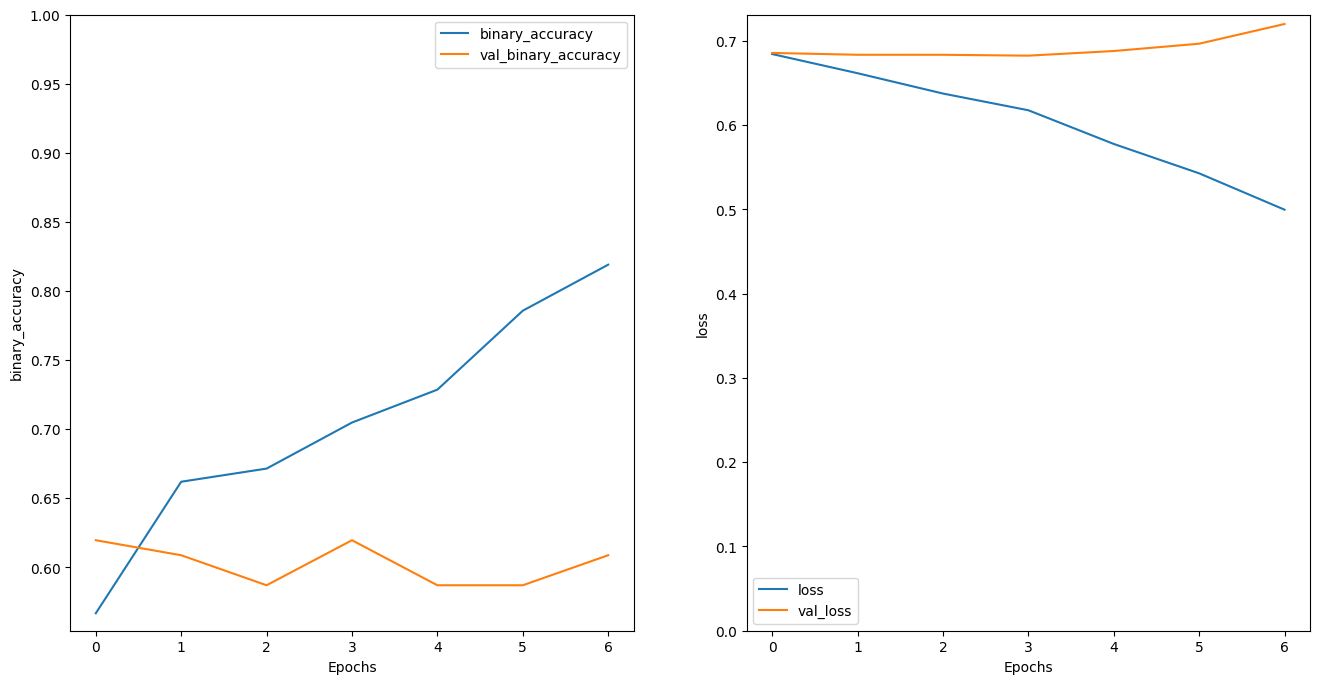

In [ ]:
model.load_weights(_checkpoint_path)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.BinaryAccuracy()])

test_loss, test_pre, test_recc, test_acc = model.evaluate(_test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test Precision:', test_pre)
print('Test Recall:', test_recc)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'binary_accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
question = [normalize('Добрый день, у меня пробный месяц. Не работает синхронизация со Сбербанком и Промсвязьбанком. Это потому что пробная подписка или это в принципе у всех сбой?'),
            normalize('Добрый день, у меня пробный месяц. Не работает синхронизация со Сбербанком и Промсвязьбанком. Это потому что пробная подписка или это в принципе у всех сбой?')]
answer = [normalize('синхронизация со Сбербанком и Промсвязьбанком не зависит от подписки. не у всех сбой.'.lower()),
          normalize('Я раздумываю над платной подпиской только из-за того, что есть синхронизация с банками. То есть вначале работала, а потом перестала. Нужно все переустановить?')]

print(question)
print(answer)

predictions = model.predict((np.array(question), np.array(answer)))
print(predictions)

['добрый день пробный месяц работать синхронизация сбербанк промсвязьбанк это пробный подписка это принцип сбой', 'добрый день пробный месяц работать синхронизация сбербанк промсвязьбанк это пробный подписка это принцип сбой']
['синхронизация сбербанк промсвязьбанк зависеть подписка сбой', 'раздумывать платный подписка синхронизация банк вначале работать перестать нужно переустановить']
1/1 [==============================] - 10s 10s/step
[[0.5273482 ]
 [0.45733157]]


In [ ]:
predictions = model.predict((np.array(_data_features1_test), np.array(_data_features2_test)))
Y_pred = get_real_preds(predictions)
print(Y_pred)

3/3 [==============================] - 0s 22ms/step
[1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1
 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0]


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

print(precision_score(_data_labels_test, Y_pred , average="macro"))
print(recall_score(_data_labels_test, Y_pred , average="macro"))
print(f1_score(_data_labels_test, Y_pred , average="macro"))

0.6384783798576903
0.6195652173913043
0.6061162079510702


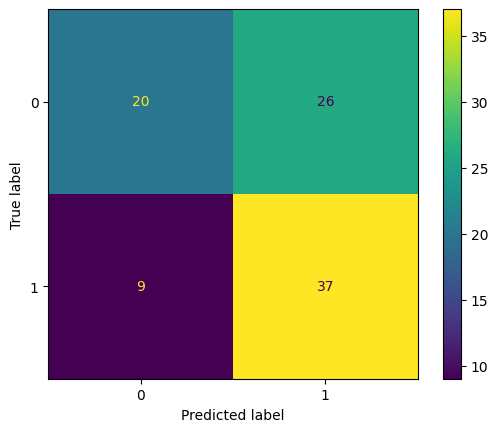

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_real = confusion_matrix(_data_labels_test, Y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_real, display_labels=[0, 1])
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

target_names = ['NO', 'GOOD']
print(classification_report(_data_labels_test, Y_pred, target_names=target_names))

              precision    recall  f1-score   support

          NO       0.69      0.43      0.53        46
        GOOD       0.59      0.80      0.68        46

    accuracy                           0.62        92
   macro avg       0.64      0.62      0.61        92
weighted avg       0.64      0.62      0.61        92

